## **Airport weekly percentage of flights delayed due to weather over total delayed flights**

In this notebook we compute the weekly percentages of delays that are due to weather, throughout the entire data set.

The percentage is computed as the ratio between the number of flights with a weather delay and the total number of flights with a delay.

More formally:

\begin{equation}
WeeklyPercentageOfWeatherDelays(week) = \frac{CountOfWeatherDelays(week)}{CountOfDelays(week)} * 100
\end{equation}

>

\begin{equation}
CountOfWeatherDelays(week) = \sum_{d\space in \space days(week)} WeatherDelayedFlights(d)
\end{equation}


\begin{equation}
WeatherDelayedFlights(day) = \sum_{i\space in \space flights(day)}x_i
\end{equation}


\begin{equation}
x_i = \begin{cases} 1, & \text{if} \space \space flight_i[WeatherDelay] > 0 \\ 0, & \text{otherwise} \end{cases}
\end{equation}

>

\begin{equation}
CountOfDelays(week) = \sum_{d\space in \space days(week)} DelayedFlights(d)
\end{equation}



\begin{equation}
DelayedFlights(day) = \sum_{i\space in \space flights(day)}y_i \space 
\end{equation}

\begin{equation}
y_i = 
\begin{cases} 
1, & \text{if} \space \space flight_i[CarrierDelay] > 0 \\ 
1, & \text{if} \space \space flight_i[WeatherDelay] > 0 \\ 
1, & \text{if} \space \space flight_i[NASDelay] > 0 \\ 
1, & \text{if} \space \space flight_i[SecurityDelay] > 0 \\ 
1, & \text{if} \space \space flight_i[LateAircraftDelay] > 0 \\
0, & \text{otherwise} \end{cases}
\end{equation}


### Assumptions

- Flights that have been cancelled are not considered in the percentage computation

#### Execution mode

If development mode is turned on, all the calculations will be performed on a reduced instance of the data set.

This allows to *save computation time* while developing.

In [1]:
# development mode
# False when performing real analytics
DEV = False

### threads to be used to run spark worker nodes locally
spark_local_threads = 4

# default transformed dataset path
transformed_dataset_path = '../dataset/02_cache_weekly_delays_due_to_weather.parquet'
missings_dataframe_path = '../dataset/02_cache_weekly_delays_due_to_weather_missings.pkl'

#### Find and import Apache Spark on current machine

In [2]:
import findspark
findspark.init()

In [3]:
# imports
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

import numpy as np
import pandas as pd

from pathlib import Path

from missing_values_utils import *

#### Create a new session

In [4]:
# Build a Spark SQL Session for DataFrames
master = 'local[{}]'.format(spark_local_threads)
appName = 'Weekly delays due to weather'
spark = SparkSession  \
    .builder          \
    .appName(appName) \
    .master(master)   \
    .getOrCreate()

### Load data

If there exists a cached version of the already transformed dataset, just load it and skip all the unnecessary computation.

In [5]:
do_computation = True

if not DEV and Path(transformed_dataset_path).is_dir():
    df = spark.read.load(transformed_dataset_path)
    do_computation = False

Try to load the optimized parquet format data set. If parquet data set is not found, load full compressed data sets, reduce and save them.

In [6]:
from preprocessing_utils import *

if do_computation:
    if DEV:
        # DEV preprocessing
        perform_DEV_dataset_preprocessing(spark)
    else:
        # Production preprocessing
        perform_dataset_preprocessing(spark)

Starting preprocessing of ../dataset/*.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset.parquet



In [7]:
# Load the parquet dataset
if do_computation:
    if DEV:
        # Load DEV dataset
        df = load_DEV_preprocessed_dataset(spark)
    else:
        # Load production dataset
        df = load_preprocessed_dataset(spark)

Peprocessed dataset loaded.
../dataset/preprocessed_dataset.parquet


### Attributes selection

In [8]:
if do_computation:
    # Keep only the dimensions we need
    df = df.select('Year', 'Month' ,'DayofMonth', 'DayOfWeek', 'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay', 'Cancelled')
    # Explore the schema
    df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- CarrierDelay: string (nullable = true)
 |-- WeatherDelay: string (nullable = true)
 |-- NASDelay: string (nullable = true)
 |-- SecurityDelay: string (nullable = true)
 |-- LateAircraftDelay: string (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [9]:
# get years from dataset
if do_computation:
    df_years = df.select('Year').distinct().toPandas()['Year']
else:
    df_years = list(df.columns)
    df_years.remove('WeekOfYear')

df_years = sorted(df_years)
print(df_years)

[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]


### Missing values exploration and exclusion

In [10]:
df.count()

91469371

In [11]:
df, df_missing = get_df_missing_and_drop_all_null(df, do_computation, missings_dataframe_path)

Years examined:
 [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]

Missing values inspection:
0  null values in:  Year
0  null values in:  Month
0  null values in:  DayofMonth
0  null values in:  DayOfWeek
57263835  null values in:  CarrierDelay
57263835  null values in:  WeatherDelay
57263835  null values in:  NASDelay
57263835  null values in:  SecurityDelay
57263835  null values in:  LateAircraftDelay
0  null values in:  Cancelled


        Count  MissingsCount  MissingsPercentage
1994  5180048        5180048            1.000000
1995  5327435        5327435            1.000000
1996  5351983        5351983            1.000000
1997  5411843        5411843            1.000000
1998  5384721        5384721            1.000000
1999  5527884        5527884            1.000000
2000  5683047        5683047            1.000000
2001  5967780        5967780            1.000000
2002  5271359        5271359            1.000000
2003  6488540        2672742

In [12]:
df.count()

34205536

In [13]:
if do_computation:
    df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- CarrierDelay: string (nullable = true)
 |-- WeatherDelay: string (nullable = true)
 |-- NASDelay: string (nullable = true)
 |-- SecurityDelay: string (nullable = true)
 |-- LateAircraftDelay: string (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [14]:
if do_computation:
    # cast delays to integer
    df = df.withColumn('CarrierDelay', df['CarrierDelay'].cast(IntegerType()))
    df = df.withColumn('WeatherDelay', df['WeatherDelay'].cast(IntegerType()))
    df = df.withColumn('NASDelay', df['NASDelay'].cast(IntegerType()))
    df = df.withColumn('SecurityDelay', df['SecurityDelay'].cast(IntegerType()))
    df = df.withColumn('LateAircraftDelay', df['LateAircraftDelay'].cast(IntegerType()))

In [15]:
if do_computation:
    df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [16]:
if do_computation:
    df.describe('WeatherDelay').show()

+-------+-----------------+
|summary|     WeatherDelay|
+-------+-----------------+
|  count|         34205536|
|   mean|0.788340635854968|
| stddev|9.434347179856653|
|    min|                0|
|    max|             1510|
+-------+-----------------+



### Compute weekly-percentage analytics

In [17]:
# Drop cancelled flights
if do_computation:
    df = df.drop(df['Cancelled'] == 1)
    df = df.drop('Cancelled')

In [18]:
# compute the week number
if do_computation:

    # function to get the week number
    def week_year(year, month, day):
        import datetime
        datetime = datetime.datetime(year, month, day) 
        return datetime.isocalendar()[1]
    week_year = F.udf(week_year, IntegerType())

    df = df.withColumn('WeekOfYear', week_year(df['Year'], df['Month'], df['DayofMonth']))

In [19]:
if do_computation:
    # Flights that have a WeatherDelay
    weather_delayed_flights = df.filter(df.WeatherDelay > 0)

    # Flights that have a Delay
    delayed_flights = df.filter((df.CarrierDelay > 0)  | \
                                (df.WeatherDelay > 0)  | \
                                (df.NASDelay > 0)      | \
                                (df.SecurityDelay > 0) | \
                                (df.LateAircraftDelay > 0))

    # Number of times per week flights had a weather delay or a general delay  
    weather_delays = weather_delayed_flights.groupBy('Year', 'WeekOfYear').count()
    general_delays = delayed_flights.groupBy('Year', 'WeekOfYear').count()

    weather_delays = weather_delays.select('Year', 'WeekOfYear', weather_delays['count'].alias('WeatherDelayedCount'))
    general_delays = general_delays.select('Year', 'WeekOfYear', general_delays['count'].alias('DelayedCount'))


    weather_delays.show(10)
    general_delays.show(10)

+----+----------+-------------------+
|Year|WeekOfYear|WeatherDelayedCount|
+----+----------+-------------------+
|2008|        35|               1413|
|2005|        29|               3018|
|2005|        49|               3513|
|2007|         6|               2165|
|2007|        52|               3271|
|2005|         5|               1267|
|2007|        28|               2940|
|2005|        51|               1584|
|2005|        25|               1653|
|2008|        28|               3249|
+----+----------+-------------------+
only showing top 10 rows

+----+----------+------------+
|Year|WeekOfYear|DelayedCount|
+----+----------+------------+
|2008|        35|       19977|
|2005|        29|       37064|
|2005|        49|       34575|
|2007|         6|       31743|
|2007|        52|       47949|
|2005|         5|       19279|
|2007|        28|       42737|
|2005|        51|       32616|
|2005|        25|       26598|
|2008|        28|       39097|
+----+----------+------------+
only sho

In [20]:
# Join the tables
if do_computation:
    df = weather_delays.join(general_delays, ['Year', 'WeekOfYear'])

In [21]:
# Compute the weekly percentage
if do_computation:
    df = df.withColumn('WeeklyWeatherDelaysPercentage', (df.WeatherDelayedCount / df.DelayedCount) * 100)
    
    df = df.select('Year', 'WeekOfYear', 'WeeklyWeatherDelaysPercentage')

In [22]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- WeeklyWeatherDelaysPercentage: double (nullable = true)



#### Data format optimazion

In [23]:
# dataset transformation so to have:
# - for each year a column with the weekly delays due to weather
# - have the dataset rows beign 53: weeks in a year
if do_computation:
    for y in df_years:
        df = df.withColumn(str(y) + '_val', df.Year == y)
        df = df.withColumn(str(y) + '_val', df[str(y) + '_val'].cast(IntegerType()))
        df = df.withColumn(str(y), df[str(y) + '_val'] * df.WeeklyWeatherDelaysPercentage)
        df = df.drop(str(y) + '_val')

    df = df.drop('WeeklyWeatherDelaysPercentage')

    # do the sum so that the columns will shrink all to the same size of 366 rows
    df = df.groupBy('WeekOfYear')        \
           .sum()                                \
           .drop('Year', 'sum(Year)', 'sum(WeekOfYear)') \
           .orderBy('WeekOfYear')

    # rename colums as year name
    for y in df_years:
        df = df.withColumnRenamed('sum({})'.format(y), str(y))

In [24]:
if do_computation:
    df.write.mode('overwrite').save(transformed_dataset_path, format='parquet')

In [25]:
df.printSchema()

root
 |-- WeekOfYear: integer (nullable = true)
 |-- 1994: double (nullable = true)
 |-- 1995: double (nullable = true)
 |-- 1996: double (nullable = true)
 |-- 1997: double (nullable = true)
 |-- 1998: double (nullable = true)
 |-- 1999: double (nullable = true)
 |-- 2000: double (nullable = true)
 |-- 2001: double (nullable = true)
 |-- 2002: double (nullable = true)
 |-- 2003: double (nullable = true)
 |-- 2004: double (nullable = true)
 |-- 2005: double (nullable = true)
 |-- 2006: double (nullable = true)
 |-- 2007: double (nullable = true)
 |-- 2008: double (nullable = true)



In [26]:
pdf = df.toPandas()

In [27]:
# update index to match the week number!
pdf.index = pdf.WeekOfYear
pdf.sort_index(inplace=True)

In [28]:
pdf.head(70)

,WeekOfYear,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
WeekOfYear,,,,,,,,,,,,,,,,
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.181055,9.818844,10.399091,7.978184,5.764160,5.413967
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.981086,8.481738,7.740806,7.520523,4.672217
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,10.169623,12.223646,7.978457,13.588165,7.545312
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.275242,9.174275,5.473945,5.135864,7.088481
5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,13.350591,6.571918,6.139684,9.032457,8.993209
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,10.386727,5.847001,7.460445,6.820401,7.388503
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.465179,5.296064,9.886998,10.745894,8.851687
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.241170,8.220696,6.405354,7.832080,7.703139
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.097480,6.349771,5.551478,6.337833,5.759261


##### Data visualization functions

Scroll down to see the charts

In [29]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib

import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
fig_size=[15,10]
title_size=20

In [31]:
def get_years_df(years):
    """
    Return the dataframe of the selected years 
    """
    years = [str(y) for y in range(*years)]
    return pdf[years]


def plot_weather_time_series(years):
    # select requested years from dataframe 
    df = get_years_df(years)
    
    title = 'Weekly weather delays percentage'
    

    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Weeks', size=16)
    ax.set_ylabel('Percentage', size=16)
    ax.set_title('Weekly weather delays percentage', pad=20)

    plt.xlim(xmin=0, xmax=54)
    df.plot(grid=True, xticks=range(0, 53, 4), ax=ax)
    plt.legend(loc='best')

    
def plot_average_weather_delays(years):
    # select requested years from dataframe 
    df = get_years_df(years)    
    averages = []
    for y in range(*years):
        averages.append(df[str(y)].mean())

    labels = [str(y) for y in range(*years)]
    
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    fig, ax = plt.subplots()
    indexes = np.arange(len(averages))
    
    rects = ax.bar(indexes, averages, label=labels, color='orange')

    # add percentages on bars
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 0.1,
                str(np.round(height, decimals=2)) + '%',
                ha='center', va='bottom', color='k', size=13)
        
    ax.set_xlabel('Years', size=16)
    ax.set_ylabel('Percentage', size=16)
    ax.set_title('Average of weather delays percentages', pad=20)
    
    ax.set_xticks(indexes)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.legend(loc='best', labels=['Weather delay percentage'])
    plt.show()



In [32]:
def ui_callback(years):
    years = (int(years[0]), int(years[1]) + 1)  #due to range() function

    plot_weather_time_series(years)
    plot_average_weather_delays(years)


# Years selection range
years_w = widgets.SelectionRangeSlider(options=[(str(y), y) for y in df_years],
                                       index=(9, 11),
                                       description='Years',
                                       continuous_update=False)
ui = widgets.HBox([years_w])

## Data Visualization

Analytics for weekly percentage of flights delayed due to weather are reported below.

### Missing values and valid data

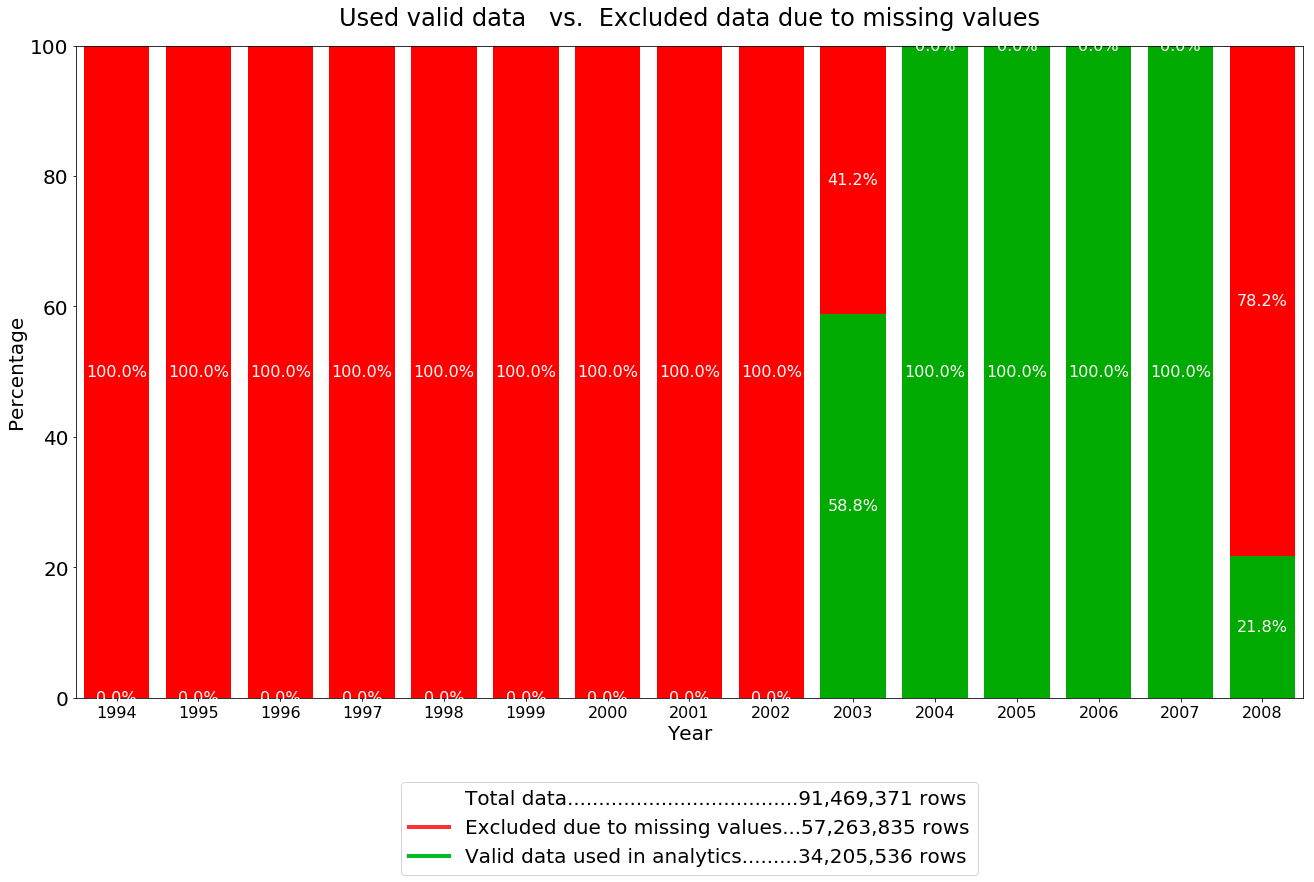

In [33]:
plot_missing_values_stacked_bar(df_missing)

### Percentage of weekly delays due to weather

A line plot is used to display percentages as a time series.

- _x axis_ is week number
- _y axis_ reports weekly percentage of flights delayed due to weather

Moreover, a bar plot is chosen to display the yearly average weekly-percentage of flights with weather delays.


#### Data discoveries

- Before year 2003 the $WhetherDelay$ attribute is always 0. Probably this attribute was not being recorded bofore that year.
- After the first week of year 2003, there is an empty gap of 20 weeks for the $WhetherDelay$ attribute but then, after that, the attribute is preset.

In [34]:
out = widgets.interactive_output(ui_callback, {'years': years_w})
display(ui, out)

Output()